### In this notebook, a simple model is trained for predicting the duration of a ride.

Data:

https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import mlflow

In [4]:
# MLflow 
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi")

ArgumentError: Invalid SQLite URL: sqlite://../mlflow.db
Valid SQLite URL forms are:
 sqlite:///:memory: (or, sqlite://)
 sqlite:///relative/path/to/file.db
 sqlite:////absolute/path/to/file.db

In [2]:
!pip install pyarrow

In [3]:
pd.__version__

'1.4.2'

In [4]:
sklearn.__version__

'1.0.2'

# EDA

In [5]:
#https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# The data is available as 'Parquet' format.
df_jan23 = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df_jan23

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [6]:
df_jan23.info()  #Total 19 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
df_jan23['duration'] = df_jan23['tpep_dropoff_datetime'] - df_jan23['tpep_pickup_datetime']
df_jan23['duration'] = df_jan23.duration.dt.total_seconds() / 60  # in minutes
df_jan23.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [8]:
df_jan23.duration.std() #42.594351241920904

42.594351241920904

In [9]:
df_jan23.duration.describe(percentiles=[0.95,0.98,0.99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64

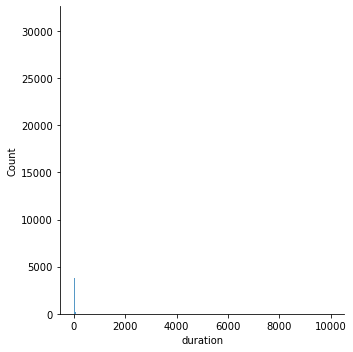

In [10]:
sns.displot(df_jan23.duration)  #Long tail

In [11]:
df_jan23_cnt_prev = df_jan23.shape[0]
df_jan23 = df_jan23[(df_jan23['duration']>=1) & (df_jan23['duration']<=60)]
df_jan23_cnt_new = df_jan23.shape[0]
fraction_left = df_jan23_cnt_new / df_jan23_cnt_prev
fraction_left # 0.9812202822125979

0.9812202822125979

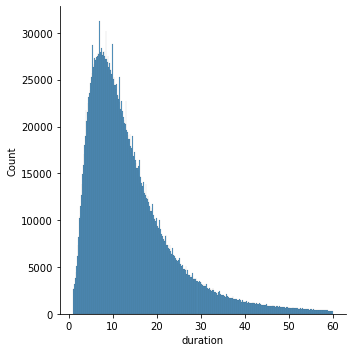

In [12]:
sns.displot(df_jan23.duration)

In [13]:
catagorical = ['PULocationID', 'DOLocationID']
df_jan23[catagorical] = df_jan23[catagorical].astype('str')
df_jan23.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3009173 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

/tmp/ipykernel_18515/3477017496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jan23[catagorical] = df_jan23[catagorical].astype('str')


In [14]:
train_dicts = df_jan23[catagorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [15]:
len(dv.feature_names_) # 515

515

In [16]:
target = 'duration'
y_train = df_jan23[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [18]:
# For now, lets just try on the X_train
y_train_pred = lr.predict(X_train)
rmse_train = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
rmse_train  # 7.65

7.649261027919939

<AxesSubplot:>

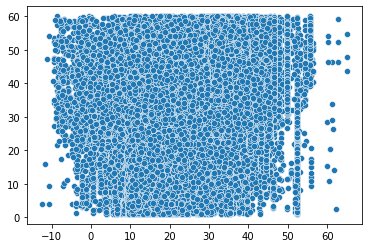

In [19]:
sns.scatterplot(x=y_train_pred, y=y_train)

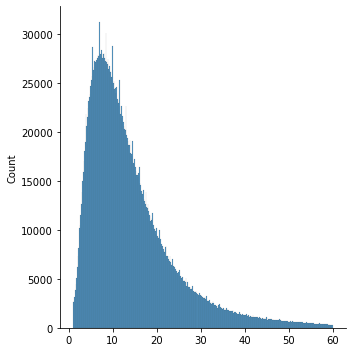

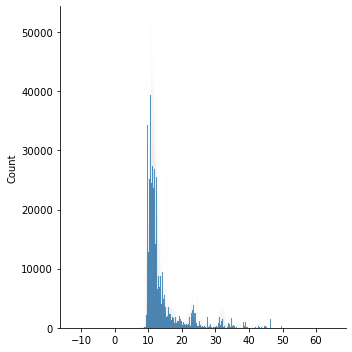

In [20]:
sns.displot(y_train)
sns.displot(y_train_pred)

### Model

In [2]:
categorical_features = ['PULocationID', 'DOLocationID']
target = 'duration'

In [3]:
def process_data(file):
    df = pd. read_parquet(file)
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df.duration.dt.total_seconds() / 60  # in minutes
    df = df[(df['duration']>=1) & (df['duration']<=60)]
    df[categorical_features] = df[categorical_features].astype('str')
    
    return df

In [ ]:
train_data = './data/yellow_tripdata_2023-01.parquet'
validation_data = './data/yellow_tripdata_2023-02.parquet'

train_df = process_data(train_data)
validation_df = process_data(validation_data)

train_X_dicts = train_df[categorical_features].to_dict(orient='records')
validation_X_dicts = validation_df[categorical_features].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_X_dicts)
y_train = train_df[target].values

X_validation = dv.transform(validation_X_dicts)
y_validation = validation_df[target].values

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Training Error

In [6]:
# For now, lets just try on the X_train
y_train_pred = lr.predict(X_train)
rmse_train = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
rmse_train  # 7.65

7.649261027919939

In [ ]:
sns.scatterplot(x=y_train_pred, y=y_train)

In [ ]:
sns.displot(y_train)
sns.displot(y_train_pred)

#### Test Error

In [7]:
y_validation_pred = lr.predict(X_validation)
rmse_train = metrics.mean_squared_error(y_validation, y_validation_pred, squared=False)
rmse_train # 7.81

7.811832638273232

<AxesSubplot:>

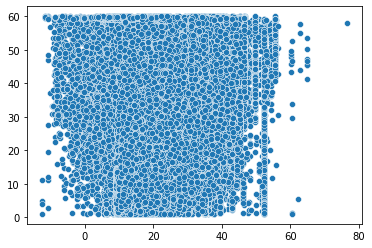

In [8]:
sns.scatterplot(x=y_validation_pred, y=y_validation)

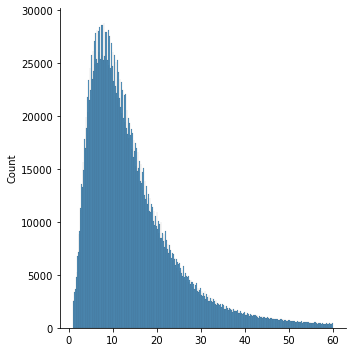

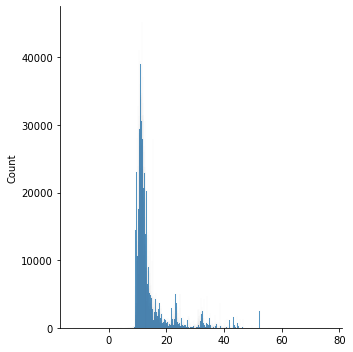

In [9]:
sns.displot(y_validation)
sns.displot(y_validation_pred)